## Inverse problems in image processing - TD 2
                                  
e-mail: jayousi@unice.fr

date: 19th Jan. 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import laplace

In [2]:
def scale(img):
    return ((img - img.min())/(img.max() - img.min()) * 255)

def snr(xref, x):
    return 20 * np.log10(np.linalg.norm(xref) / np.linalg.norm(xref-x))

# 1. Introduction

## 1.1 Forward model

* Load Barbara and scale it.

In [3]:
# load the images
x1 = scale(np.float64(plt.imread('barbara.png')))

* Convolve the image with a low pass Gaussian kernel ($\sigma_k=5$ pixels).
* Add Gaussian noise ($\sigma_n=5$).
* Show the original image, the blurred version, and then the noisy blurred version.

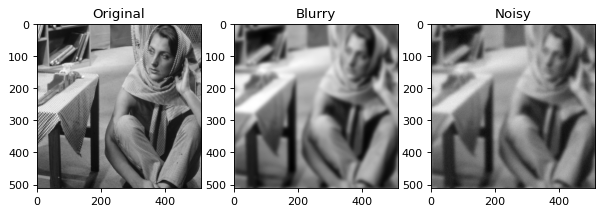

In [4]:
# Create gaussian kernel
sigma = 5
n = x1.shape[0]
t = np.concatenate( (np.arange(0, n/2+1), np.arange(-n/2, -1)) )

Y, X = np.meshgrid(t, t)
h = np.exp( -(X**2+Y**2)/(2.0*float(sigma)**2) )
h = h / np.sum(h)  # normalisation


# Convolution (in Fourier)
hf = np.real(np.fft.fft2(h))
y1_bl = np.real(np.fft.ifft2(hf * np.fft.fft2(x1)))


# Add Gaussian noise
sig = 5                     # SD of Gaussian noise
y1 = y1_bl + sig * np.random.randn(*np.shape(x1))

plt.figure(figsize=(9, 4), dpi=80)
plt.subplot(131)
plt.imshow(x1, cmap='gray')
plt.title('Original')
plt.subplot(132)
plt.imshow(y1_bl, cmap='gray')
plt.title('Blurry')
plt.subplot(133)
plt.imshow(y1, cmap='gray')
plt.title('Noisy')
plt.show()

* Compute the SNR between "Barbara" and its noisy blurred version. 

In [5]:
print('SNR:',"{:.2f}".format(snr(x1, y1)), 'dB')

SNR: 14.41 dB


# 2. Introduction to Inverse Problems

A realistic blurring model writes: 
$$
y= Ax + \eta
$$
where $A$ is the linear transformation and $x$, $y$ and $\eta$ are viewed as vectors.  It is important, as we have observed in the lab, that even though we use the notations $A$, we do not actually construct the matrix. In this lab, we considerer that the noise, $\eta$ follows a multidimensional normal law of covarience $\sigma^2 I$ and of mean the zero vector. So, we can write: $\eta \sim \mathcal{N}(0, \sigma^2 I)$. 

 
We want to find the unknown image $x$ from the observation $y$. We use the maximum likelihood estimator which maximizes the likelihood $L(y,x)$ given the unknown image $x$. When the noise is Gaussian, the MLE is given by

\begin{equation*}
 \hat{x} = \arg\min_x \, \|Ax-y\|_2^2 
\end{equation*}

## 2.1 Deconvolution Example

Let $y$ be a blured image (without adding any noise). Compute the exact solution $\hat{x}$ that satisfies $\nabla J(\hat{x})=0$, using FFT.

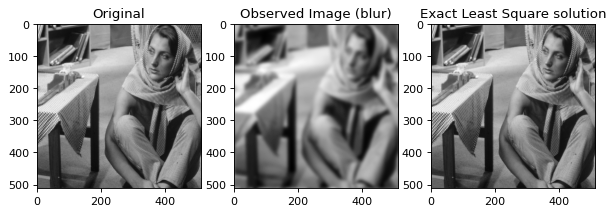

In [6]:
# -- Exact Least Square solution using Fourier
hf_adj = hf.conj()  # H*, H*x  is calculated by ifft2(Hetoile.*fft2(x));
x1sol = np.real(np.fft.ifft2(hf_adj*np.fft.fft2(y1_bl)/(abs(hf)**2)))

plt.figure(figsize=(9, 4), dpi=80)
# plot x
plt.subplot(131)
plt.imshow(x1, cmap='gray')
plt.title('Original')
# plot y
plt.subplot(132)
plt.imshow(y1_bl, cmap='gray')
plt.title('Observed Image (blur)')
# plot xsol
plt.subplot(133)
plt.imshow(x1sol, cmap='gray')
plt.title('Exact Least Square solution')
#plt.title('Exact Least Square solution using Fourier')
plt.show()

Compute again the exact solution $\hat{x}$ that satisfies $\nabla J(\hat{x})=0$, using FFT on the noisy image. What do you observe?

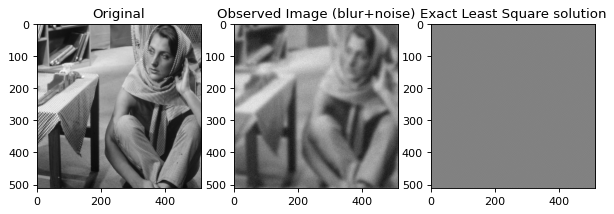

In [7]:
sig = 10                     # SD of Gaussien noise
y1 = y1_bl + sig*np.random.randn(*np.shape(x1))

hf_adj = hf.conj()  # H*, H*x  is calculated by ifft2(Hetoile.*fft2(x));
x1sol = np.real(np.fft.ifft2(hf_adj*np.fft.fft2(y1)/(abs(hf)**2)))

plt.figure(figsize=(9, 4), dpi=80)
# plot x
plt.subplot(131)
plt.imshow(x1, cmap='gray')
plt.title('Original')
# plot y
plt.subplot(132)
plt.imshow(y1, cmap='gray')
plt.title('Observed Image (blur+noise)')
# plot xsol
plt.subplot(133)
plt.imshow(x1sol, cmap= 'gray')
plt.title('Exact Least Square solution')
#plt.title('Exact Least Square solution using Fourier')
plt.show()

#### Gradient Descent algorithm
In order to find the minimum, instead of using Exact Least Square solution, we can make use of the gradient descent algorithm. Recall that it is an iterative algorithm, where each update is given by:

\begin{equation}
 x_{k+1} = x_k - \alpha 2 A^*(A x_k - y)/
\end{equation}

with $k = 0 \dots K-1$, $x_0 = y$ and $0 < \alpha \leq \frac{1}{2}$.

Complete the gradient descent function below, plot the cost/error function along with the resulting image. Ensure that the cost function consistently decreases (debug your code if necessary!). What observations can you make for different values of K?

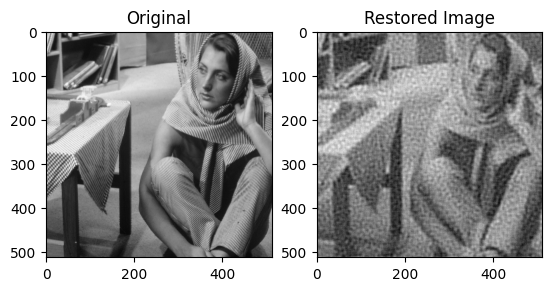

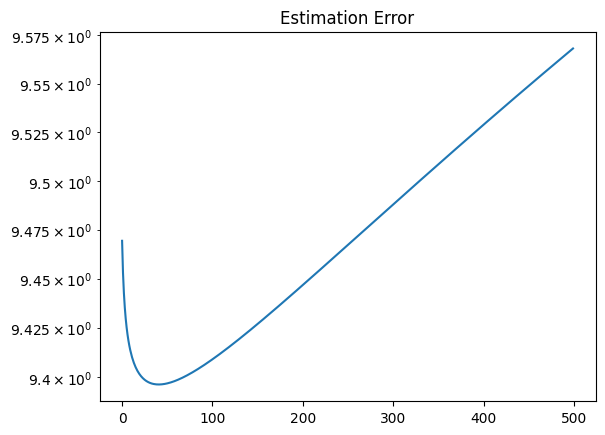

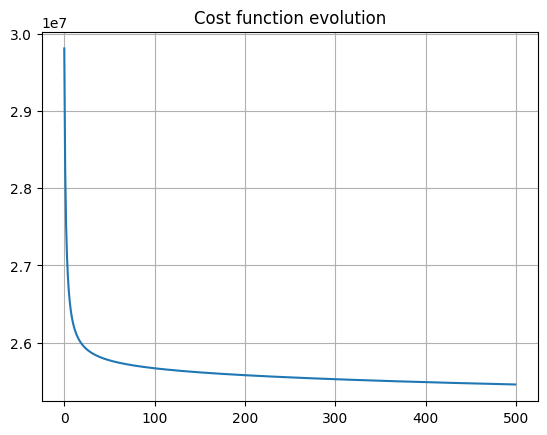

In [8]:
# -- Gradient Descent algo

#-- Parameters
alpha = 0.4                   # Step
K = 500                       # Number of iterations

# Initialisation
xk = y1
J = np.zeros(shape=(K))    # Cost
err = np.zeros(shape=(K))  # Error

# Main loop
k = 0
while k < K:
    #  gradient
    gradJ = 2 * np.real(np.fft.ifft2(hf_adj * np.fft.fft2(np.fft.ifft2(hf*np.fft.fft2(xk))-y1)))
    # update xk
    xk = xk-alpha*gradJ
    # Calculate cost and Error
    J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf*np.fft.fft2(xk))-y1))**2  #  Cost function
    err[k] = np.linalg.norm(xk-x1)  # error between xk and the original image
    k += 1


# -- plots
# plot x
plt.subplot(1,2,1)
plt.imshow(x1, cmap='gray')
plt.title('Original')
# plot xk
plt.subplot(1,2,2)
plt.imshow(xk, cmap= 'gray')
plt.title('Restored Image')
plt.show()

# Estimation Error
plt.figure()
plt.semilogy(np.log(err))
plt.title('Estimation Error')

# Cost Function
plt.figure()
plt.plot(J)
plt.title('Cost function evolution')
plt.grid(True)

* Write your answer here

K:  0


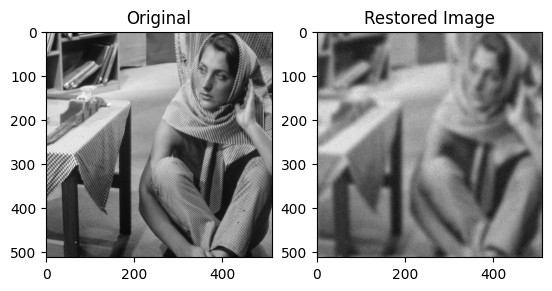

K:  20


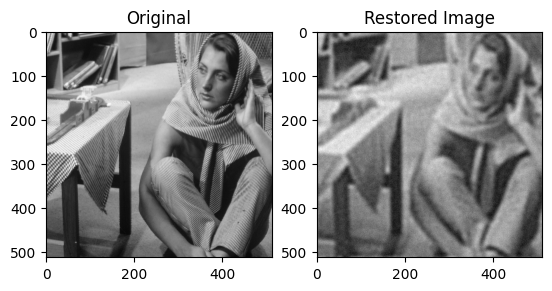

K:  40


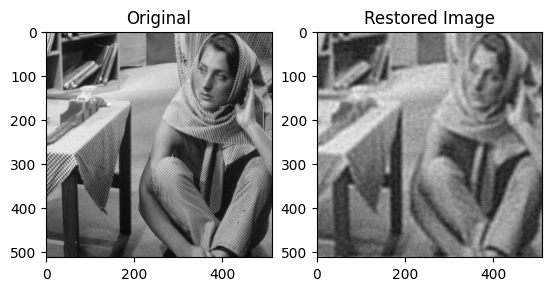

K:  60


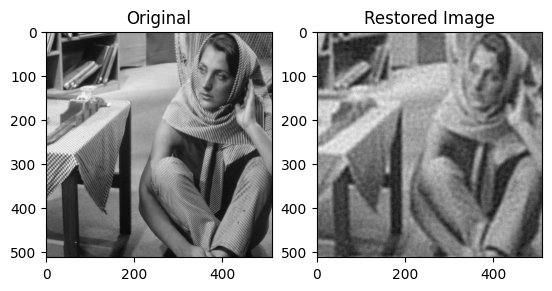

K:  80


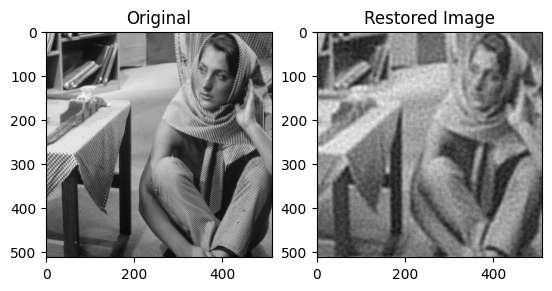

K:  100


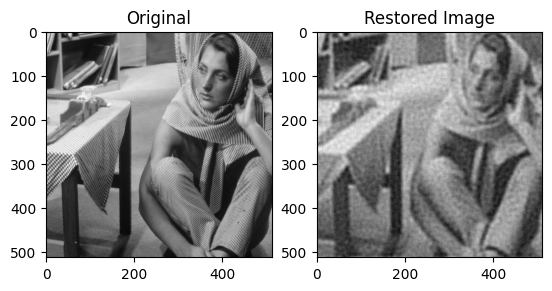

K:  120


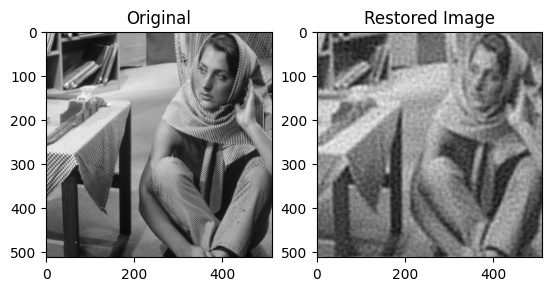

K:  140


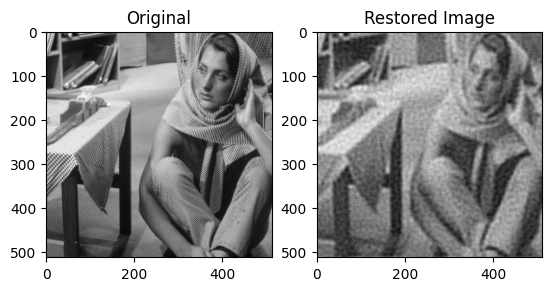

K:  160


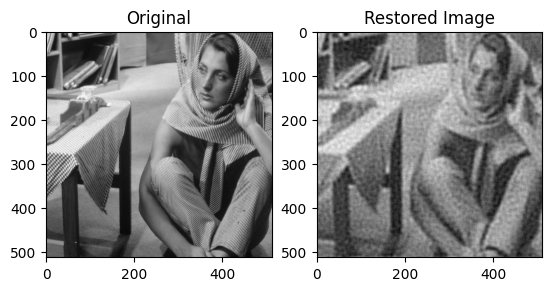

K:  180


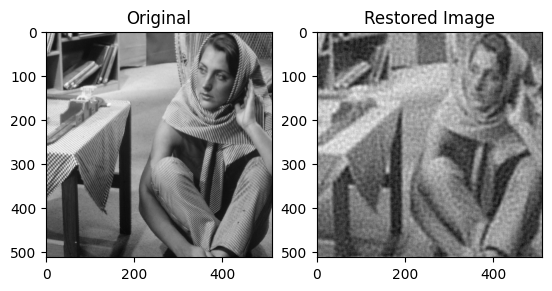

K:  200


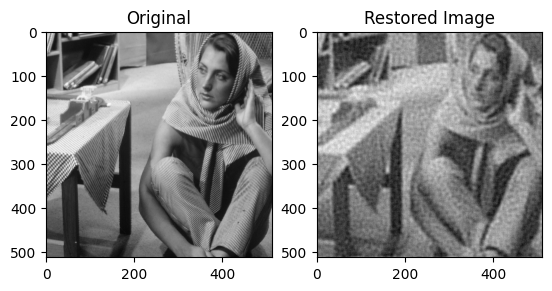

K:  220


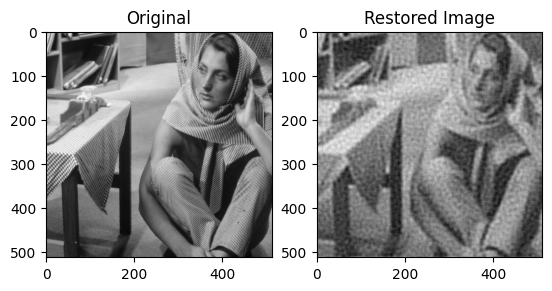

K:  240


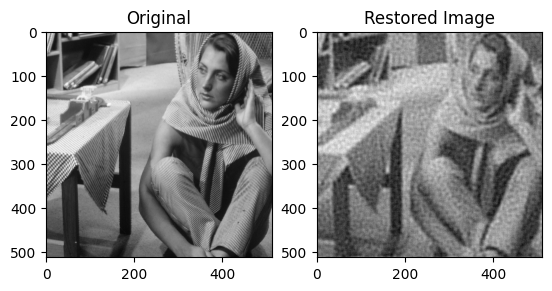

K:  260


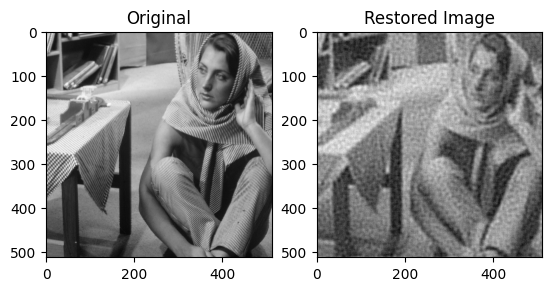

K:  280


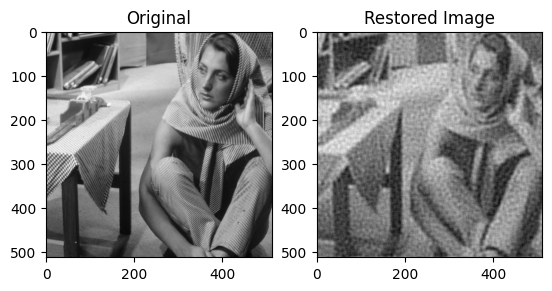

K:  300


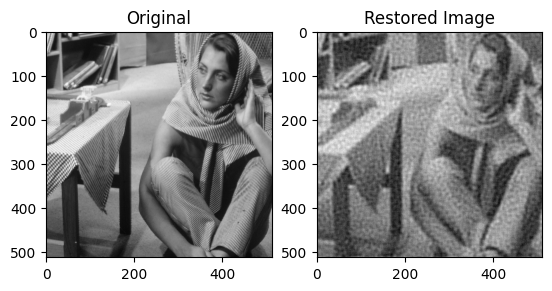

K:  320


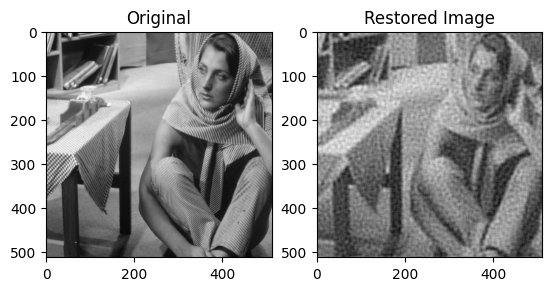

K:  340


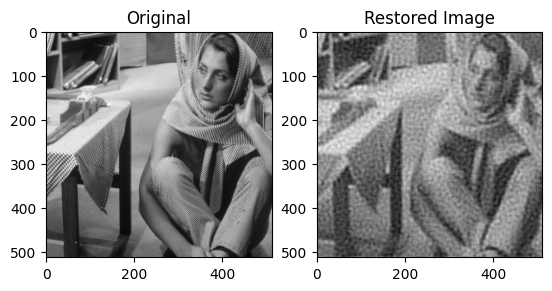

K:  360


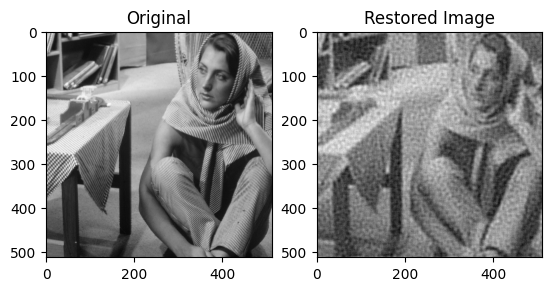

K:  380


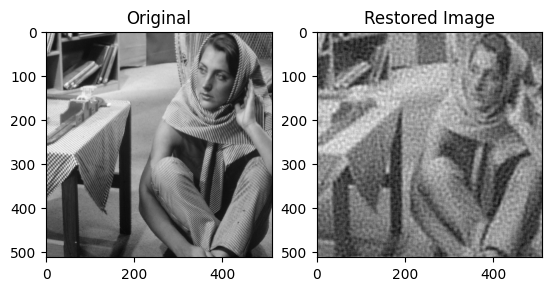

K:  400


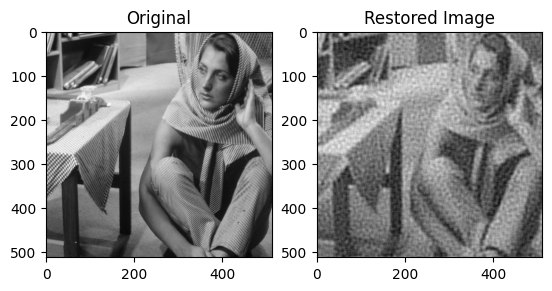

K:  420


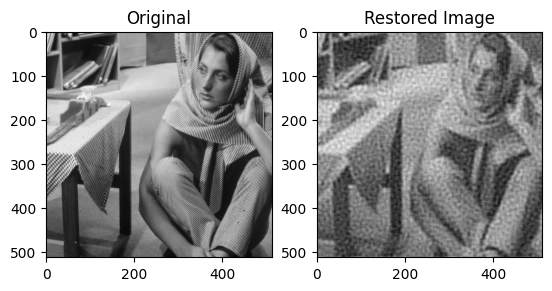

K:  440


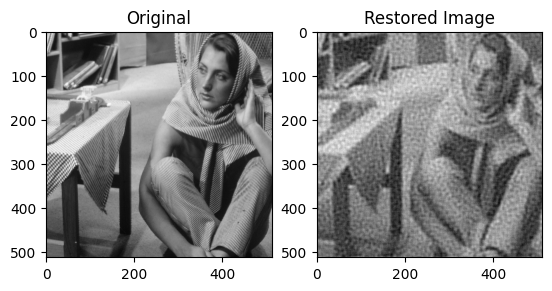

K:  460


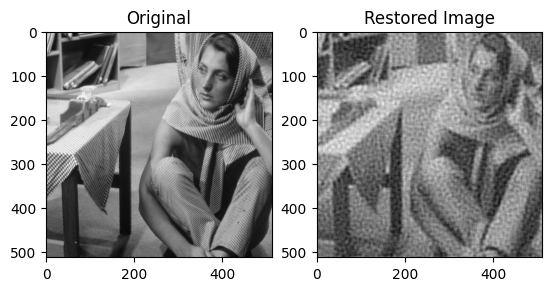

K:  480


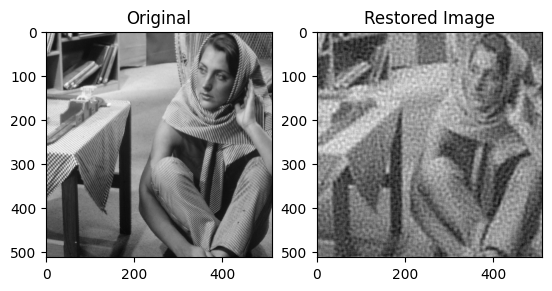

In [9]:
# Initialisation
xk = y1
J = np.zeros(shape=(K))    # Cost
err = np.zeros(shape=(K))  # Error

K = 500                       # Number of iterations

# Main loop
k = 0
while k < K:
    #  gradient
    gradJ = 2 * np.real(np.fft.ifft2(hf_adj * np.fft.fft2(np.fft.ifft2(hf*np.fft.fft2(xk))-y1)))
    # update xk
    xk = xk-alpha*gradJ
    # Calculate cost and Error
    J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf*np.fft.fft2(xk))-y1))**2  #  Cost function
    err[k] = np.linalg.norm(xk-x1)  # error between xk and the original image
    # -- plots
    if k % 20 == 0:
        print("K: ",k)
        # plot x
        plt.subplot(1,2,1)
        plt.imshow(x1, cmap='gray')
        plt.title('Original')
        # plot xk
        plt.subplot(1,2,2)
        plt.imshow(xk, cmap= 'gray')
        plt.title('Restored Image')
        plt.show()
    k += 1

best_k = np.where(err == err.min())
worst_k = np.where(err == err.max())

> As the value of K increases, a clearer image is restored (improved blurred image), but more noise is generated, and the error increases after minima. In our case, the best image is generated when k=40.

## Tikhonov regularisation


We will now consider the following penalised criterion $$\mathcal{J}(x):= \|Ax-y\|_2^2 + \lambda\mathcal{R}(x)$$ where $\mathcal{R}(\cdot)$ is a regularisation term. 


* Explain why this term is introduced.


> Regularization helps in reducing the impact of noise on the estimated solution. By introducing a regularization term that encourages certain properties in the solution (e.g., smoothness or sparsity), we can obtain more robust and stable results.

**Write your answer here**

We consider these two regularisation terms in this lab: 
\begin{align*}
    \mathcal{R}_1(x) &=  \|x\|_2^2 \\
    \mathcal{R}_2(x) &=  \|\nabla x\|_2^2
\end{align*}
where $\lambda>0$ is a regularisation parameter that controls the weight of the regularisation, and $$\|\nabla x \|_2 = \sum_{i,j}((\nabla x)_{i,j})^2$$
with
\begin{align}
&(\nabla x)_{i,j} = \big( (\nabla x)_{i,j}^1,(\nabla x)_{i,j}^2 \big)\\
&(\nabla x)_{i,j}^1 = (x_{i+1,j}-x_{i,j})\quad\text{if}\quad i<N,\qquad 0 \quad\text{if}\quad i=N \\
&(\nabla x)_{i,j}^2 = (x_{i,j+1}-x_{i,j})\quad\text{if}\quad j<N,\qquad 0 \quad\text{if}\quad j=N \\
\end{align}
where $N \times N$ is the size of the image.

* Compute their gradients and then complete the following python functions.

In [10]:
def reg_1(x):
    return np.linalg.norm(x)**2

def grad_reg_1(x): 
    return 2*x

def reg_2(x):
    gx, gy = np.gradient(x)
    return np.sum(gx**2 + gy**2)**2

def grad_reg_2(x):
    return -laplace(x)

# Use -laplace(x) as the gradient of R_2(x) to effectively minimize the squared L2 norm of the Laplacian of the reconstructed image. 
# Using -laplace(x) as the gradient aligns with Tikhonov regularization by promoting smoothness.

* Modify the Gradient Descent function slightly to take into account $\mathcal{R}_1(\cdot)$.

In [18]:
# -- Gradient Descent algo (R_1(.))

#-- Parameters
alpha = 0.4                   # Step
K = 400                       # Number of iterations
lambd = 0.05

# Initialisation
xk_tn = y1  # tikhonov-nograd
J = np.zeros(shape=(K))    # Cost
err = np.zeros(shape=(K))  # Error

# Main loop
k = 0
while k < K:
    if (k + 1) % 50 == 0:
        print(f"Iter {k+1}/{K}")
    #  gradient
    grad = 2 * np.real(np.fft.ifft2(hf_adj * np.fft.fft2(np.fft.ifft2(hf * np.fft.fft2(xk_tn)) - y1)))
    gradJ = grad + lambd * grad_reg_1(xk_tn)

    # update xk
    xk_tn = xk_tn - alpha*gradJ

    # Calculate cost and Error
    J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf * np.fft.fft2(xk_tn))-y1))**2 + lambd*reg_1(xk_tn)  #  Cost function
    
    err[k] = np.linalg.norm(xk_tn-x1)  # error between xk and the original image
    
    k += 1

    

Iter 50/400
Iter 100/400
Iter 150/400
Iter 200/400
Iter 250/400
Iter 300/400
Iter 350/400
Iter 400/400


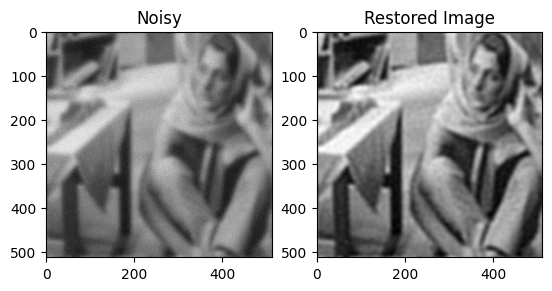

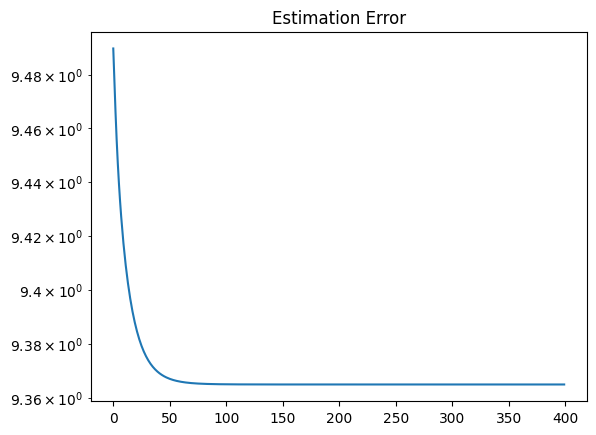

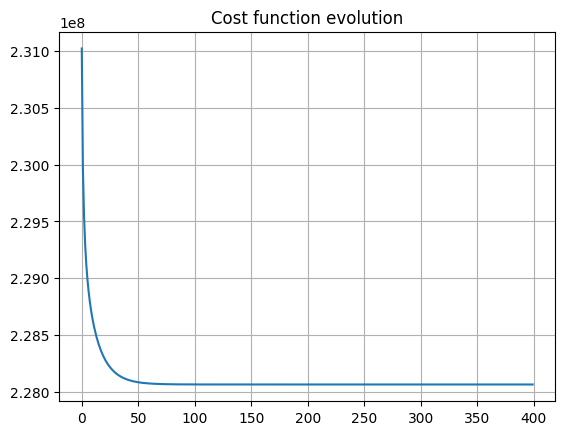

In [19]:
# -- plots
# plot x
plt.subplot(121)
plt.imshow(y1, cmap='gray')
plt.title('Noisy')
# plot xk
plt.subplot(122)
plt.imshow(xk_tn, cmap= 'gray')
plt.title('Restored Image')
plt.show()

# Estimation Error
plt.figure()
plt.semilogy(np.log(err))
plt.title('Estimation Error')

# Cost Function
plt.figure()
plt.plot(J)
plt.title('Cost function evolution')
plt.grid(True)

* Modify the Gradient Descent function slightly to take into account $\mathcal{R}_2(\cdot)$.

In [20]:
# -- Gradient Descent algo (R_2(.))

#-- Parameters
alpha = 0.4                   # Step
K = 400                       # Number of iterations
lambd = 0.3

# Initialisation
xk_tg = y1
J = np.zeros(shape=(K))    # Cost
err = np.zeros(shape=(K))  # Error

# Main loop
k = 0
while k < K:
   if (k + 1) % 50 == 0:
        print(f"Iter {k+1}/{K}")

   #  gradient
   grad = 2*np.real(np.fft.ifft2(hf_adj*np.fft.fft2(np.fft.ifft2(hf*np.fft.fft2(xk_tg))-y1)))
   gradJ = grad + lambd * grad_reg_2(xk_tg)

   # update xk
   xk_tg = xk_tg - alpha*gradJ
   # Calculate cost and Error
   J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf*np.fft.fft2(xk_tg))-y1))**2 + lambd*reg_2(xk_tn) #  Cost function
   err[k] = np.linalg.norm(xk_tg-x1)  # error between xk and the original image
   k += 1

Iter 50/400
Iter 100/400
Iter 150/400
Iter 200/400
Iter 250/400
Iter 300/400
Iter 350/400
Iter 400/400


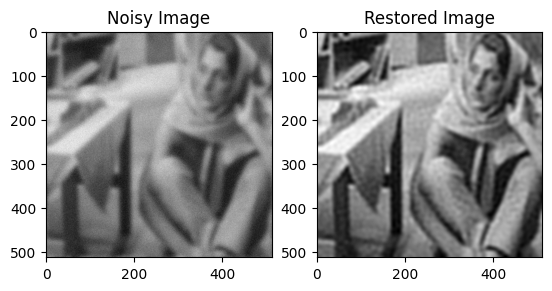

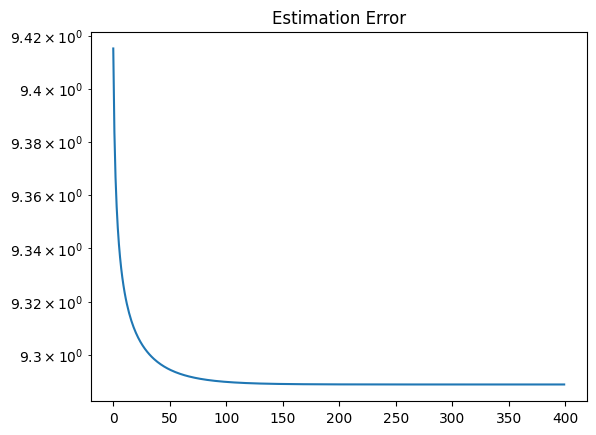

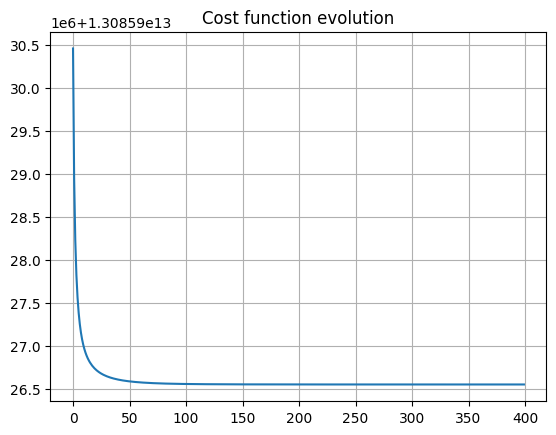

In [14]:
# -- plots
# plot x
plt.subplot(121)
plt.imshow(y1, cmap='gray')
plt.title('Noisy Image')
# plot xk
plt.subplot(122)
plt.imshow(xk_tg, cmap= 'gray')
plt.title('Restored Image')
plt.show()

# Estimation Error
plt.figure()
plt.semilogy(np.log(err))
plt.title('Estimation Error')

# Cost Function
plt.figure()
plt.plot(J)
plt.title('Cost function evolution')
plt.grid(True)

* What do each of the regularisation terms promote?

> $\mathcal{R}_1(x)$ encourages a globally smooth and continuous solution by penalizing the magnitudes of individual elements.
$\mathcal{R}_2(x)$ encourages a locally smooth and piecewise constant solution by penalizing the squared gradients in the image.

* Modify $\lambda$ to observe its influence. 

lambda:  0.001


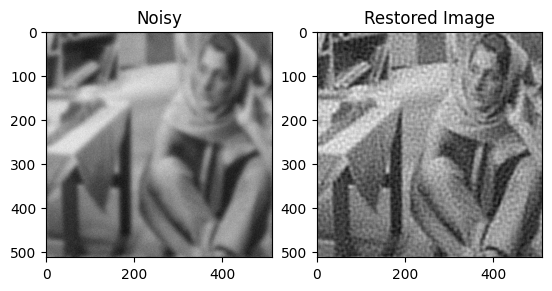

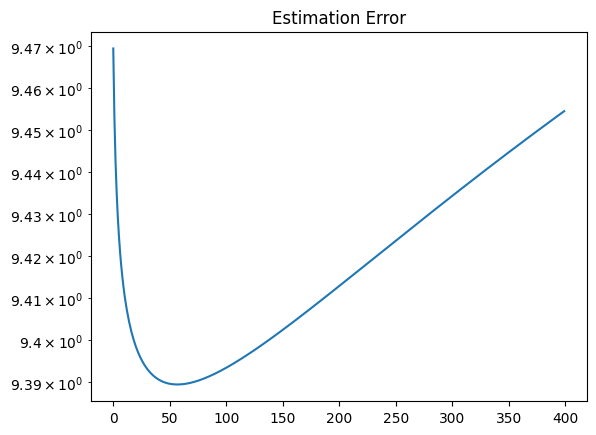

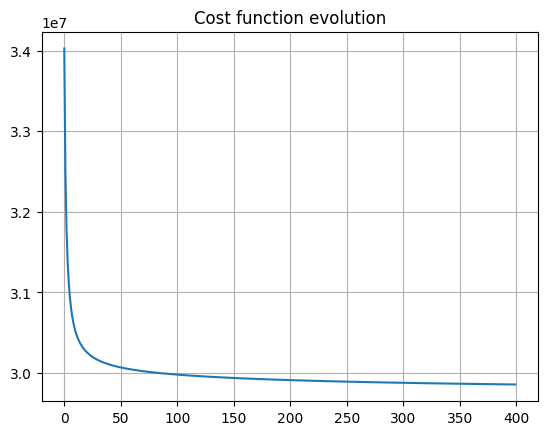

lambda:  0.01


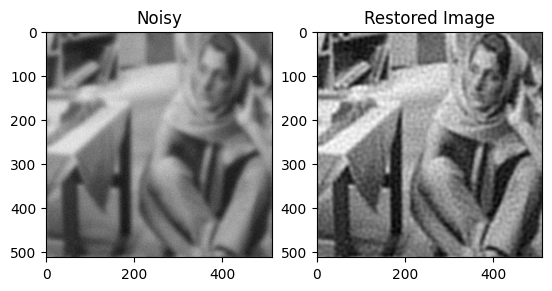

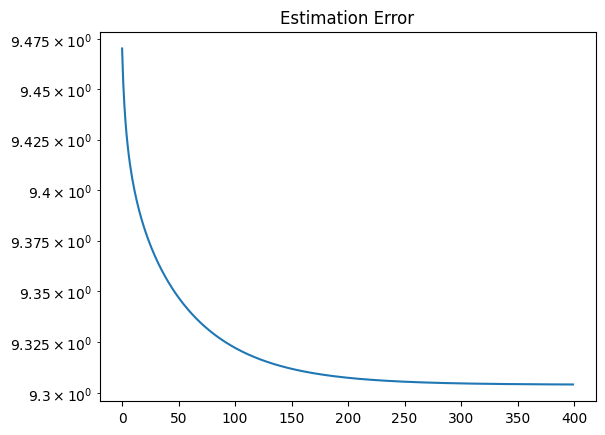

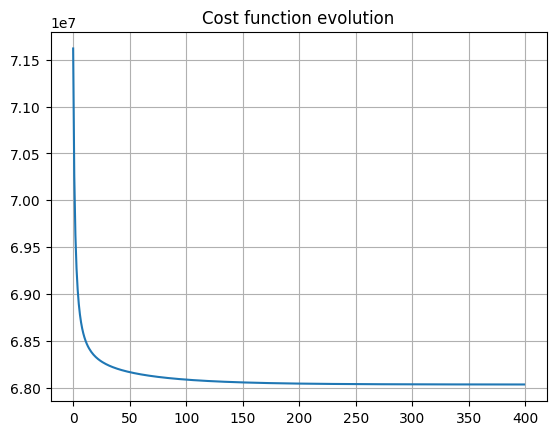

lambda:  0.05


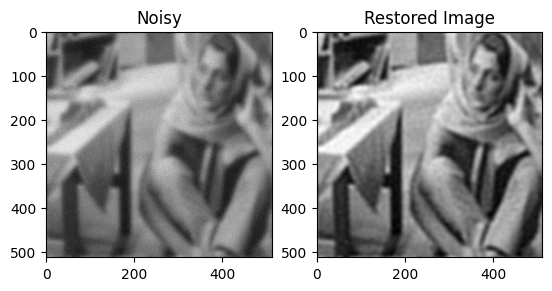

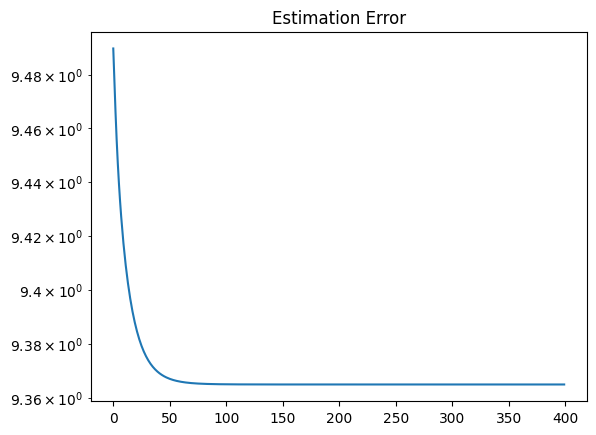

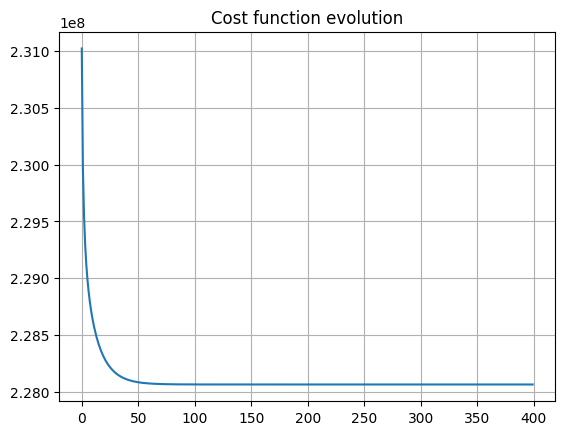

lambda:  0.1


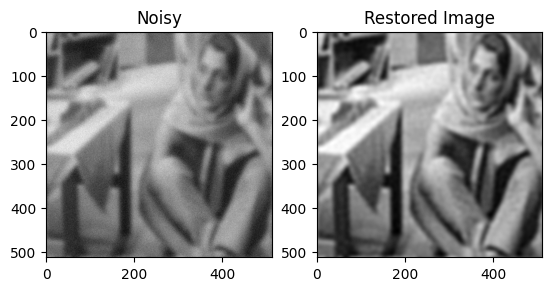

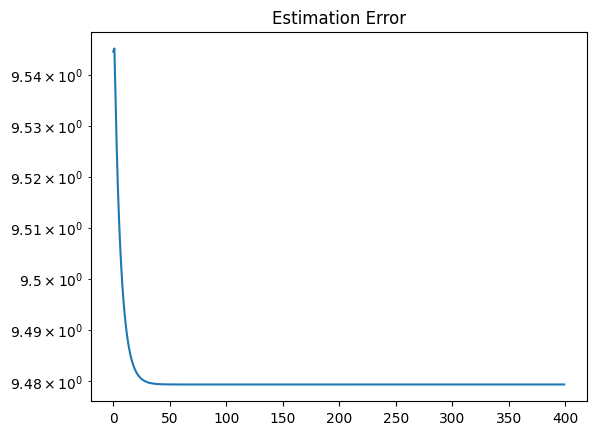

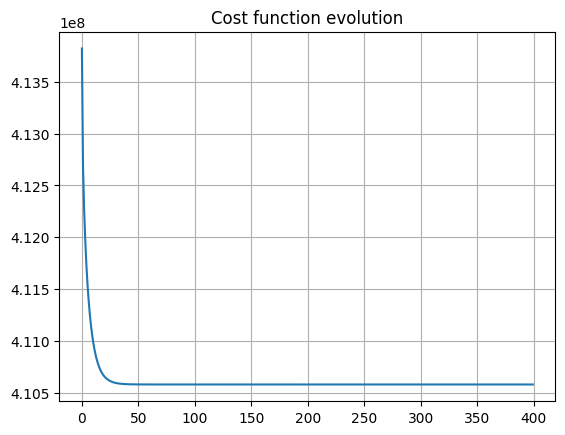

lambda:  0.3


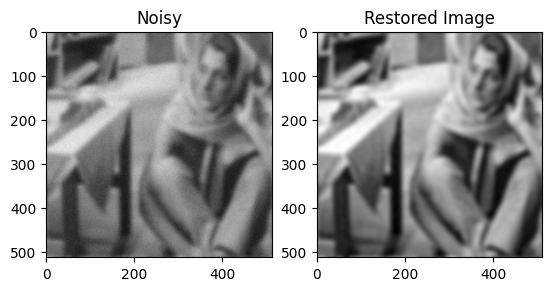

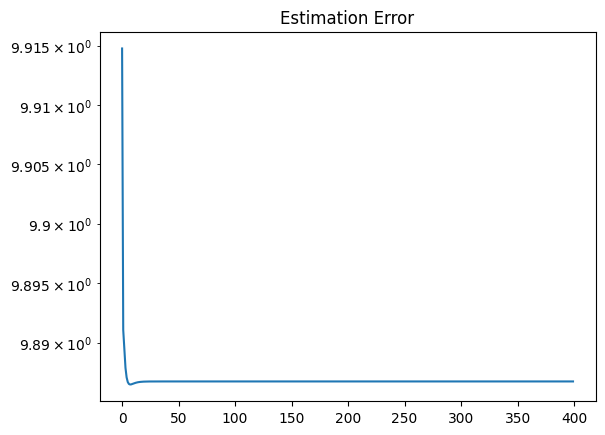

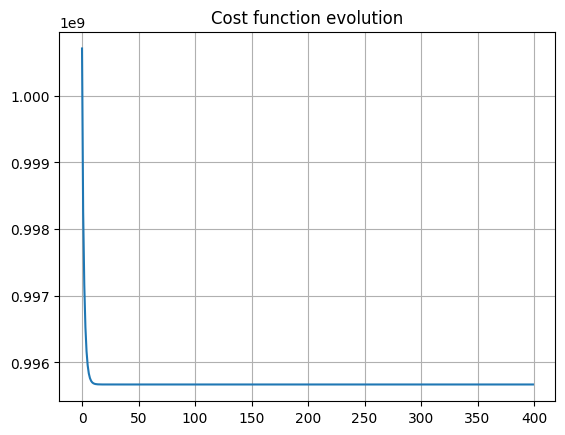

lambda:  0.5


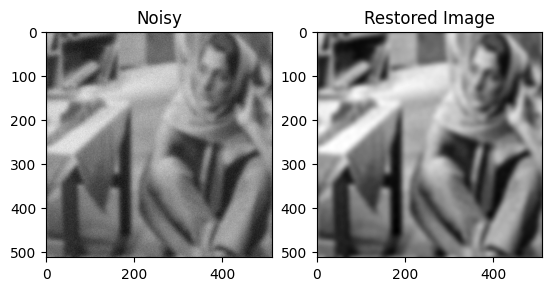

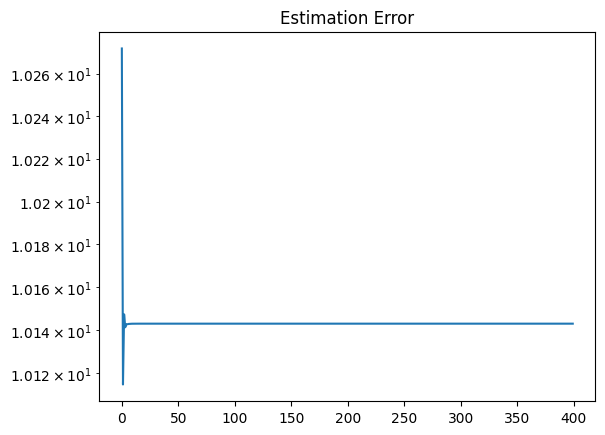

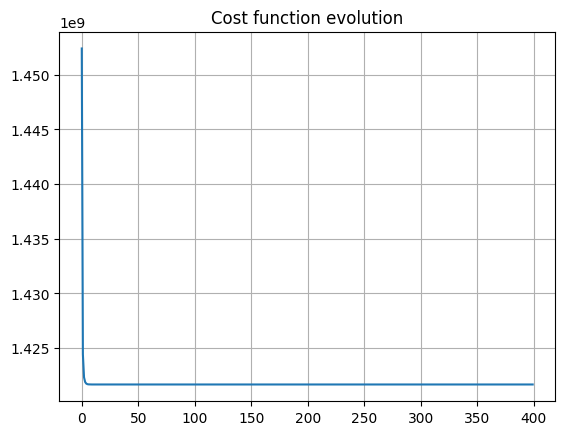

lambda:  1


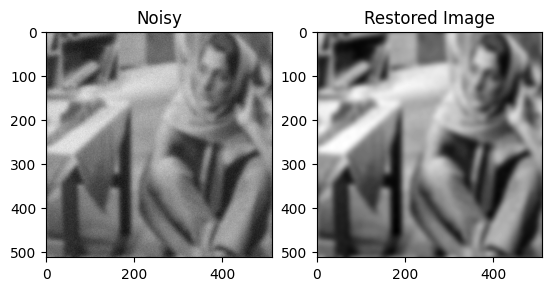

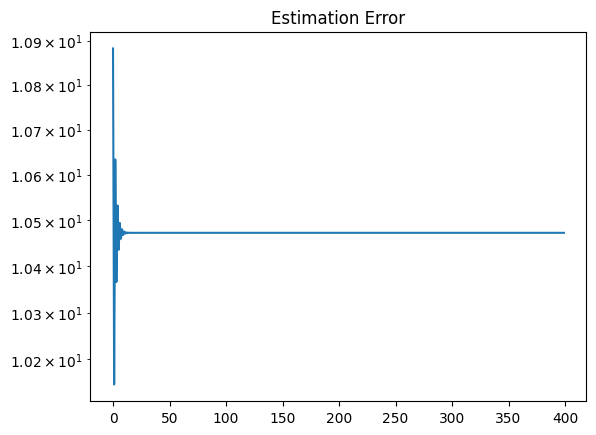

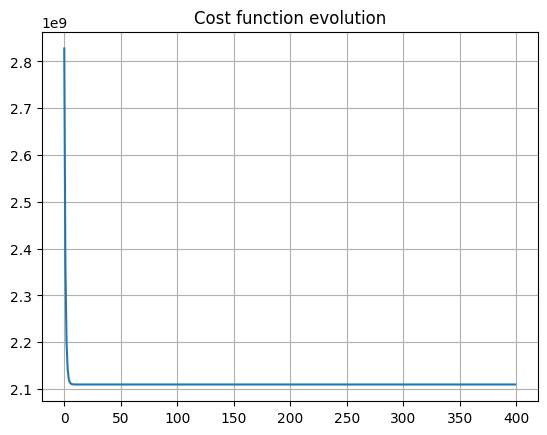

In [15]:
# -- Gradient Descent algo (R_1(.))

#-- Parameters
alpha = 0.4                   # Step
K = 400                       # Number of iterations
lambds = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 1]


for i in range(len(lambds)):
    lambd = lambds[i]
    
    # Initialisation
    xk_tn = y1  # tikhonov-nograd
    J = np.zeros(shape=(K))    # Cost
    err = np.zeros(shape=(K))  # Error
    
    # Main loop
    k = 0
    while k < K:
        #  gradient
        grad = 2 * np.real(np.fft.ifft2(hf_adj * np.fft.fft2(np.fft.ifft2(hf * np.fft.fft2(xk_tn)) - y1)))
        gradJ = grad + lambd * grad_reg_1(xk_tn)
    
        # update xk
        xk_tn = xk_tn - alpha*gradJ
    
        # Calculate cost and Error
        J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf * np.fft.fft2(xk_tn))-y1))**2 + lambd*reg_1(xk_tn)  #  Cost function
        
        err[k] = np.linalg.norm(xk_tn-x1)  # error between xk and the original image
        
        k += 1

    # -- plots
    # plot x
    print("lambda: ",lambd)
    plt.figure()
    plt.subplot(121)
    plt.imshow(y1, cmap='gray')
    plt.title('Noisy')
    # plot xk
    plt.subplot(122)
    plt.imshow(xk_tn, cmap= 'gray')
    plt.title('Restored Image')
    plt.show()
    
    # Estimation Error
    plt.figure()
    plt.semilogy(np.log(err))
    plt.title('Estimation Error')
    
    # Cost Function
    plt.figure()
    plt.plot(J)
    plt.title('Cost function evolution')
    plt.grid(True)
    plt.show()
        

lambda:  0.001


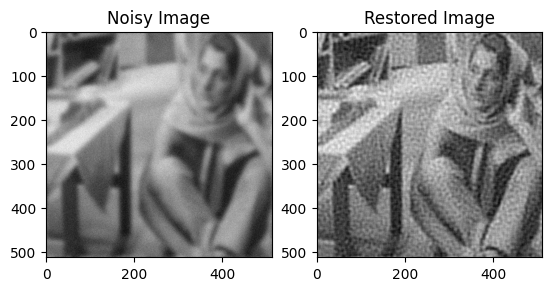

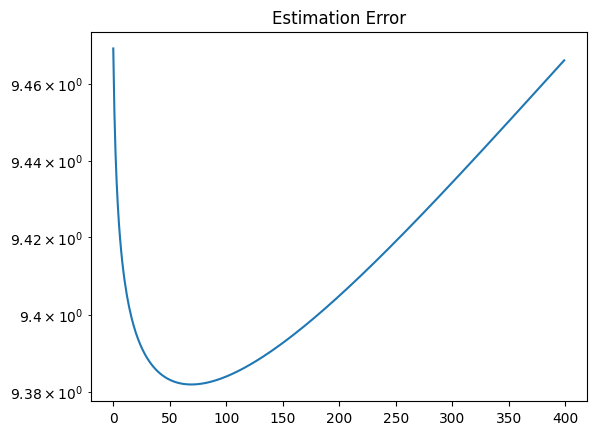

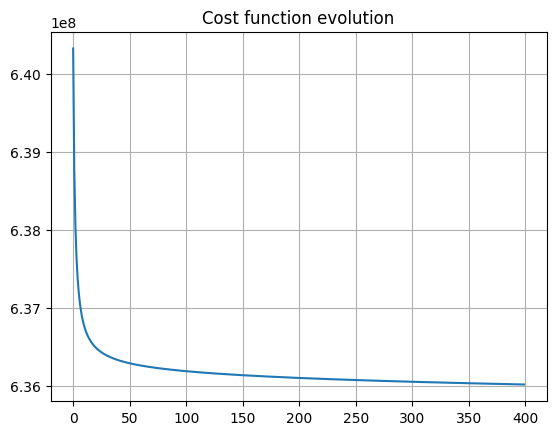

lambda:  0.01


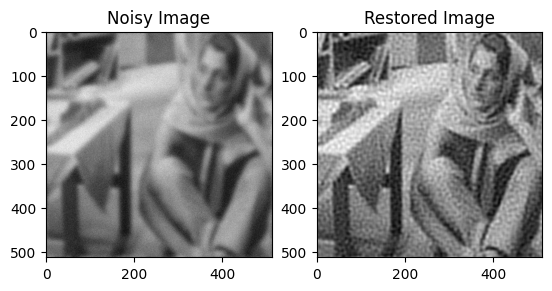

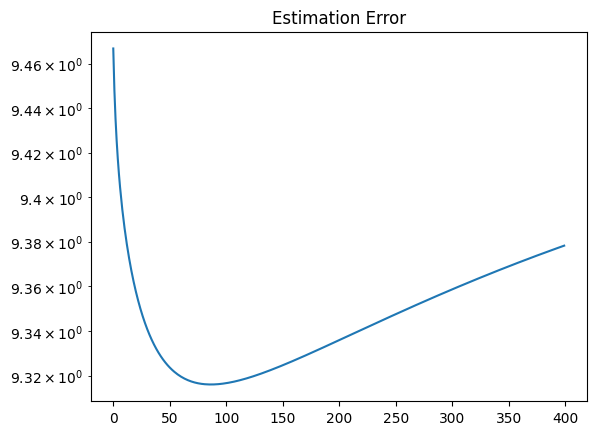

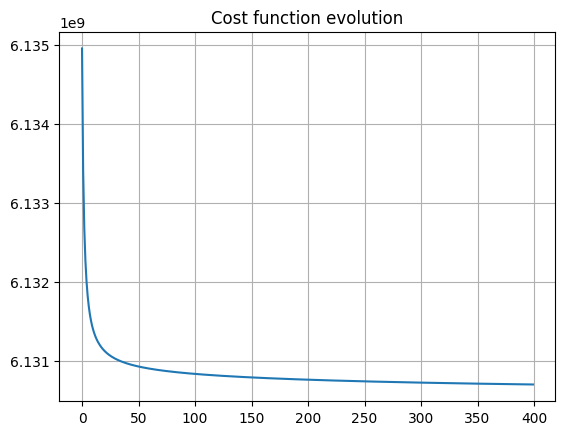

lambda:  0.05


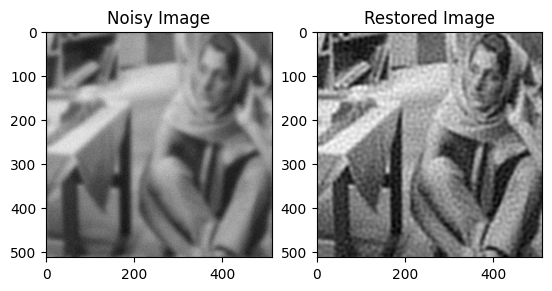

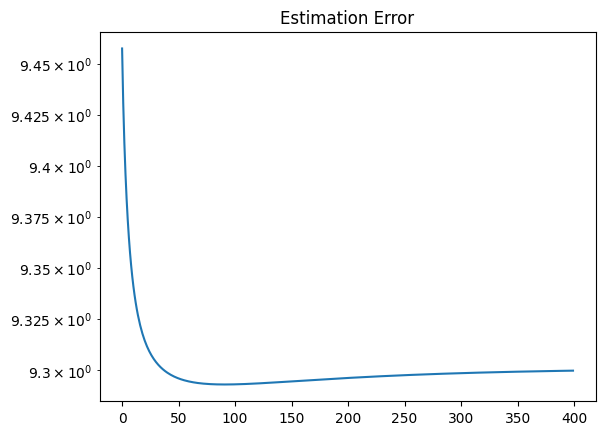

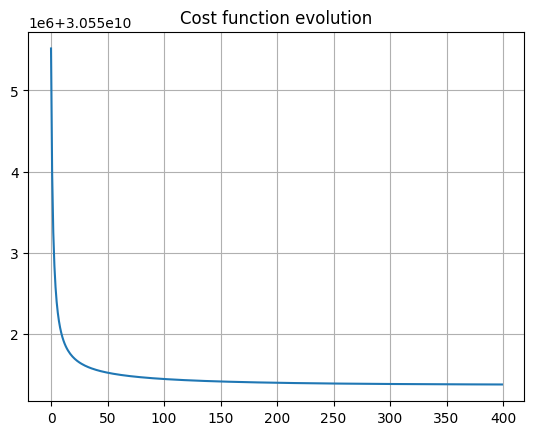

lambda:  0.1


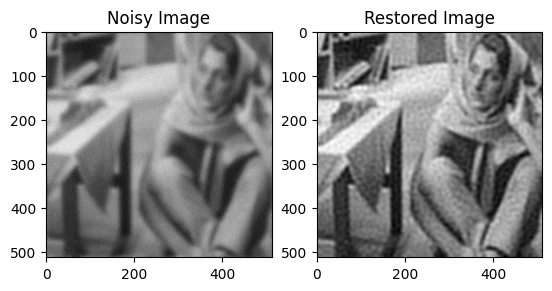

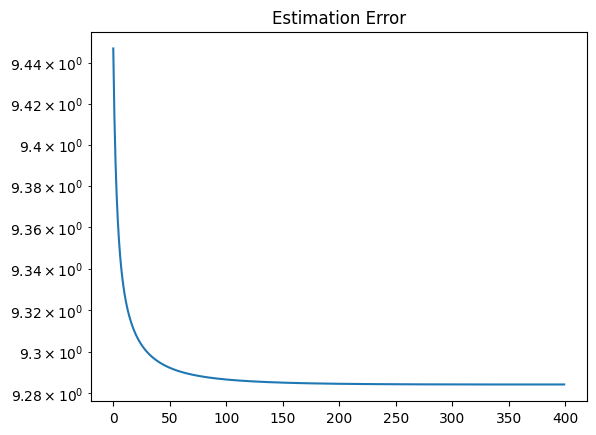

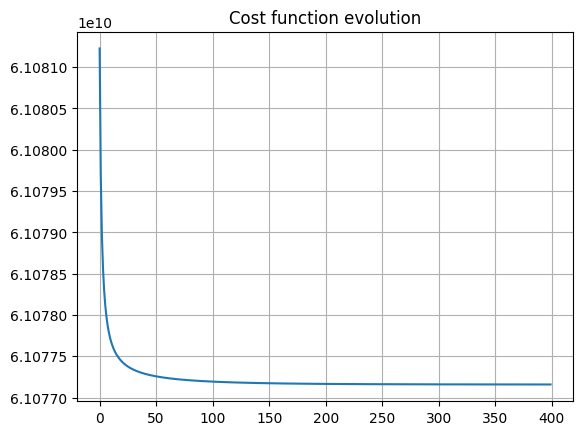

lambda:  0.3


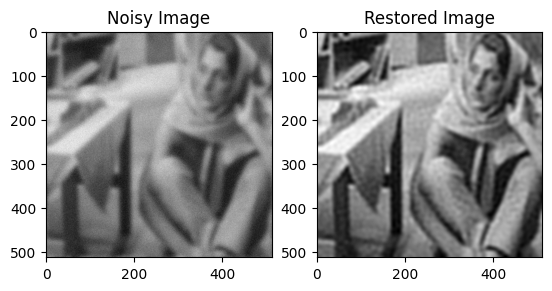

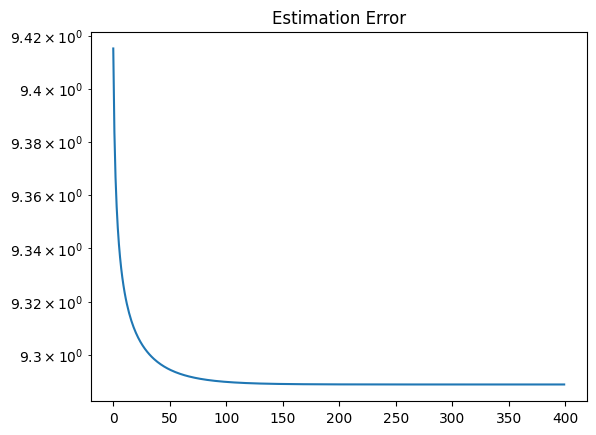

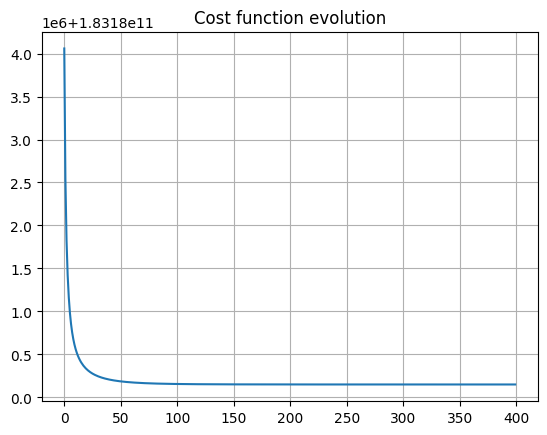

lambda:  0.5


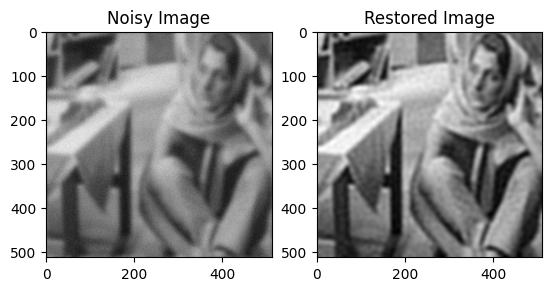

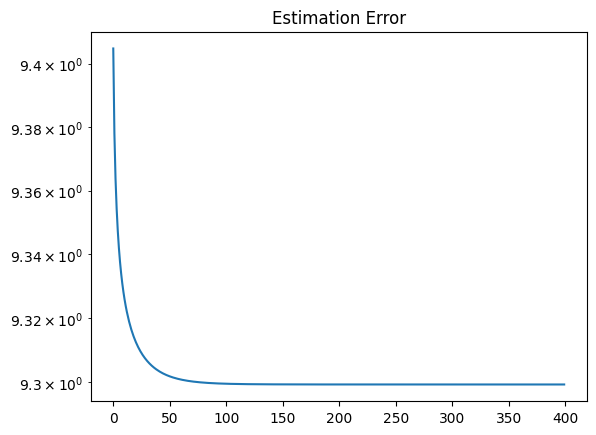

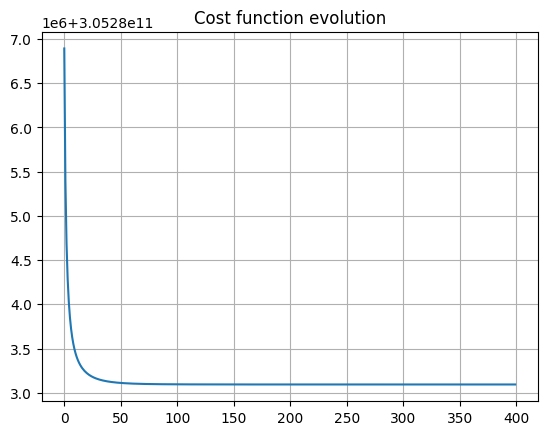

lambda:  1


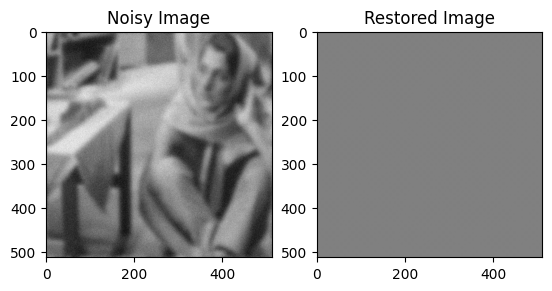

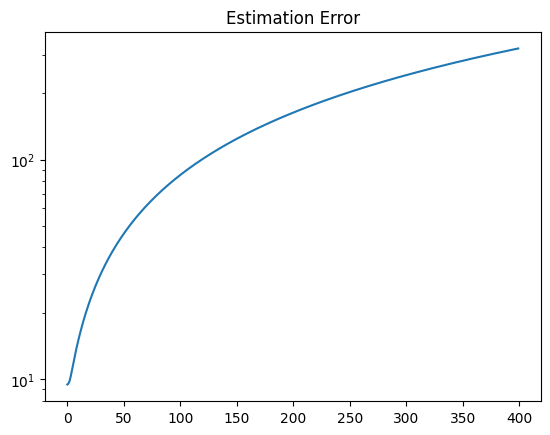

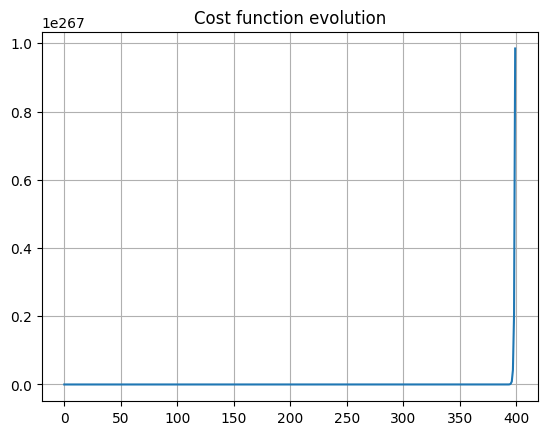

In [16]:
# -- Gradient Descent algo (R_2(.))

#-- Parameters
alpha = 0.4                   # Step
K = 400                       # Number of iterations
lambds = [0.001, 0.01, 0.05, 0.1, 0.3, 0.5, 1]

# Main loop
for i in range(len(lambds)):
    lambd = lambds[i]
    k = 0

    # Initialisation
    xk_tg = y1
    J = np.zeros(shape=(K))    # Cost
    err = np.zeros(shape=(K))  # Error
    
    # Main loop
    k = 0
    while k < K: 
       #  gradient
       grad = 2*np.real(np.fft.ifft2(hf_adj*np.fft.fft2(np.fft.ifft2(hf*np.fft.fft2(xk_tg))-y1)))
       gradJ = grad + lambd * grad_reg_2(xk_tg)
    
       # update xk
       xk_tg = xk_tg - alpha*gradJ
       # Calculate cost and Error
       J[k] = np.linalg.norm(np.real(np.fft.ifft2(hf*np.fft.fft2(xk_tg))-y1))**2 + lambd*reg_2(xk_tn) #  Cost function
       err[k] = np.linalg.norm(xk_tg-x1)  # error between xk and the original image
       k += 1


    # -- plots
    # plot x
    print("lambda: ",lambd)
    plt.figure()
    
    plt.subplot(121)
    plt.imshow(y1, cmap='gray')
    plt.title('Noisy Image')
    # plot xk
    plt.subplot(122)
    plt.imshow(xk_tg, cmap= 'gray')
    plt.title('Restored Image')
    plt.show()
    
    # Estimation Error
    plt.figure()
    plt.semilogy(np.log(err))
    plt.title('Estimation Error')
    
    # Cost Function
    plt.figure()
    plt.plot(J)
    plt.title('Cost function evolution')
    plt.grid(True)
    plt.show()

> In the case of  $\mathcal{R}_1(\cdot)$, comparing the results of $\lambda$=0.001 and $\lambda$=0.01, a better restored image is implemented when $\lambda$=0.01. However, if lambda exceeds the some extent (0.01 in my experiment), The clarity of the image decreases.
> In the case of  $\mathcal{R}_2(\cdot)$, a better restored image is implemented when $\lambda$=0.1.
> These results show that setting appropriate $\lambda$ is important when applying regulization.

* Observe the restored images, and compare them to the true image by computing the SNR. 

In [21]:
print('SNR (Noisy)',"{:.2f}".format(snr(x1, y1)), 'dB')
print('SNR (NoReg):',"{:.2f}".format(snr(x1, xk)), 'dB')
print('SNR (Tikhonov, Nograd):',"{:.2f}".format(snr(x1, xk_tn)), 'dB') # when lambd = 0.05
print('SNR (Tikhonov, Grad):',"{:.2f}".format(snr(x1, xk_tg)), 'dB') # when lambd = 0.3

SNR (Noisy) 13.90 dB
SNR (NoReg): 13.31 dB
SNR (Tikhonov, Nograd): 15.08 dB
SNR (Tikhonov, Grad): 15.74 dB


> When we use Tikhonov regularisation, we have better images with less noise(SNR is higher). Also, when we use Tikhonov regularisation, using gradient has better image with less noise than nograd.